## Выявление искуственно сгенерированных данных

In [6]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from itertools import combinations
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.metrics import silhouette_score

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


### 1. Data loading and preprocessing

In [2]:
data = pd.read_csv('../data/merged.csv')
data.head()

,"Количество отвердителя, м.%","Содержание эпоксидных групп, %","Температура вспышки, С","Потребление смолы, г/м2","Угол нашивки, град",Шаг нашивки,Плотность нашивки,"Плотность, кг/м3","Поверхностная плотность, г/м2","Модуль упругости, ГПа",Соотношение матрица-наполнитель,"Модуль упругости при растяжении, ГПа","Прочность при растяжении, МПа"
0,30.00,22.267857,100.000000,220.0,0,4.0,57.0,2030.0,210.0,738.736842,1.857143,70.0,3000.0
1,50.00,23.750000,284.615385,220.0,0,4.0,60.0,2030.0,210.0,738.736842,1.857143,70.0,3000.0
2,49.90,33.000000,284.615385,220.0,0,4.0,70.0,2030.0,210.0,738.736842,1.857143,70.0,3000.0
3,129.00,21.250000,300.000000,220.0,0,5.0,47.0,2030.0,210.0,738.736842,1.857143,70.0,3000.0
4,111.86,22.267857,284.615385,220.0,0,5.0,57.0,2030.0,210.0,753.000000,2.771331,70.0,3000.0


In [3]:
# Масштабирование в диапазоне от 0 до 1
data_scale = (data - data.min(axis=0)) / (data.max(axis=0) - data.min(axis=0))

### 2. Выявление реальных данных сопоставлением с данными литературы


| Параметр | Примеры нетипичных значений из датасета | Значения из литературы | Источник |
| --- | --- | --- | --- |
| Температура<br>отверждения,<br>°С | 300<br>349.726170752168 | 25<br>110<br>150 | - Орлов М.А. и др.. Оценка вклада адгезионной составляющей прочности полимерных базальтопластиков на эпоксидной основе / Системные технологии. – 2019. – № 30. – с. 83–93.<br>- Орлов, М. А. Разработка технологии создания элементов газотурбинного двигателя из полимерных композиционных материалов с применением автоматизированной нашивки ровингом / Дисс. на соискание уч. степ. канд. техн. наук. / М. А. Орлов. – Москва : Московский политехнический университет, 2020. – 122 с. |
| Содержание эпоксидных групп, масс. % | 17,8740999097888<br>21,0433175526934 | 22.1-23.5<br>22.5-24.0 | - ГОСТ 10587-84 Смолы эпоксидно-диановые неотвержденные.<br>- ТУ 2257-245-18826195-99 |  
| Количество отвердителя, масс. % | 111,86<br>129 | 30<br>50 | *масс.% не могут быть больше 100* |
| Поверхностная<br>плотность,<br>г/м<sup>2</sup> | 0.603740<br>1.668002<br>1.894093<br>4.099043 | от 200<br>210<br>380<br>1010 | - Орлов М.А. и др. Особенности разрушения эпоксидных базальтопластиков / XXVI Всероссийская конференция «Структура и динамика молекулярных систем». – 2020. с. 236–237.<br>- В.Б. Пономарев, А.Ц. Рапопорт. Базальтовые и базальтопластиковые материалы для строительства. Базальтовые технологии. 2012. № 1. с. 29–35<br>- Vikas, G., Sudheer, M. A Review on Properties of Basalt Fiber Reinforced. American Journal of Materials Science 2017, 7(5): 156-165 |
| Шаг нашивки,<br>мм | 0<br>0,310815338065802<br>5,70627207958085<br>7,31043751586699<br>12,8370015953315 | 4<br>5<br>7<br>9<br>10 | - Орлов М.А. и др. Способ изготовления преформ для лопаток компрессора газотурбинного двигателя / Патент 2717228 РФ МПК. – заявл. от 04.12.2018; опубл. 18.03.2020.<br>- Нелюб В.А. и др. Способ изготовления волокнистых заготовок плоской формы / Патент 2718789 РФ МПК. – заявл. от 11.10.2019; опубл. 14.04.2020. |
| Плотность<br>нашивки,<br>у.е. | 64,3019638481212<br>19,2505331367488<br>78,6232993394774 | 47 – 60 | - Орлов, М. А. Разработка технологии создания элементов газотурбинного двигателя из полимерных композиционных материалов с применением автоматизированной нашивки ровингом / Дисс. на соискание уч. степ. канд. техн. наук. / М. А. Орлов. – Москва : Московский политехнический университет, 2020. – 122 с.<br>- Нелюб В.А. и др. Способ изготовления волокнистых заготовок плоской формы / Патент 2718789 РФ МПК. – заявл. от 11.10.2019; опубл. 14.04.2020. |
| Угол нашивки,<br>град | – | 0<br>45<br>90<br>–45 | - Нелюб В.А. и др. Способ изготовления волокнистых заготовок плоской формы / Патент 2718789 РФ МПК. – заявл. от 11.10.2019; опубл. 14.04.2020.<br>- Нелюб В.А. и др. Способ изготовления многослойной волокнистой заготовки плоской формы / Патент 2736367 РФ МПК. – заявл. от 11.10.2019; опубл. 16.11.2020. |
| Модуль упругости при растяжении,<br>ГПа | – | 70<br>71.37<br>100 | Орлов М.А., Калинников А.Н., Кирейнов А.В., Шлыкова А.В. Исследование физико-механических свойств базальтовых моноволокон и их реализаций в жгутах / Химия, физика и механика материалов. № 4 (19), 2018. – С. 74 - 93 |



- <font size=4>При температуре более 200 °С эпоксидные смолы плавятся или кипят</font>  
- <font size=4>Содержание эпоксидных групп определенной марки смолы должно быть постоянным и соответствовать требованиям ГОСТ и ТУ </font>  
- <font size=4>Количество отвердителя, выраженное в массовых долях, не может превышать 100 %</font>  
- <font size=4>Распределения модуля упругости и поверхностной плотности чрезмерно смещены влево, к нулю. Близкие к нулю значения поверхностной плотности не естественны для композитных материалов.</font>  
- <font size=4>Шаг и плотность нашивки устанавливаются на швейном аппарате с ЧПУ, точность которого не может составлять 13 цифр после запятой в 1 мм</font>  

### 3. Анализ первых 40 строк датасета

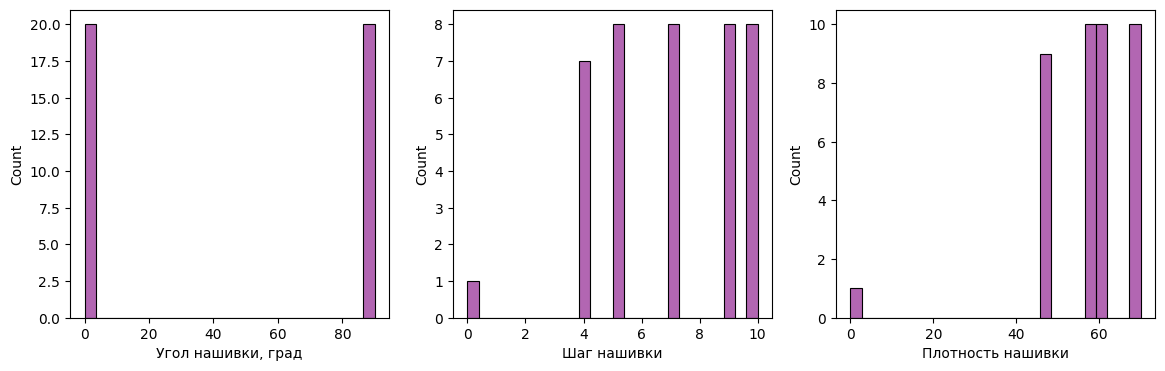

In [4]:
# Углепластик

plt.figure(figsize=(14,4))

plt.subplot(1, 3, 1)
sns.histplot(data[:40]['Угол нашивки, град'], bins=26, color='purple', alpha=0.6)

plt.subplot(1, 3, 2)
sns.histplot(data[:40]['Шаг нашивки'], bins=26, color='purple', alpha=0.6)

plt.subplot(1, 3, 3)
sns.histplot(data[:40]['Плотность нашивки'], bins=26, color='purple', alpha=0.6)
plt.show()


<Axes: >

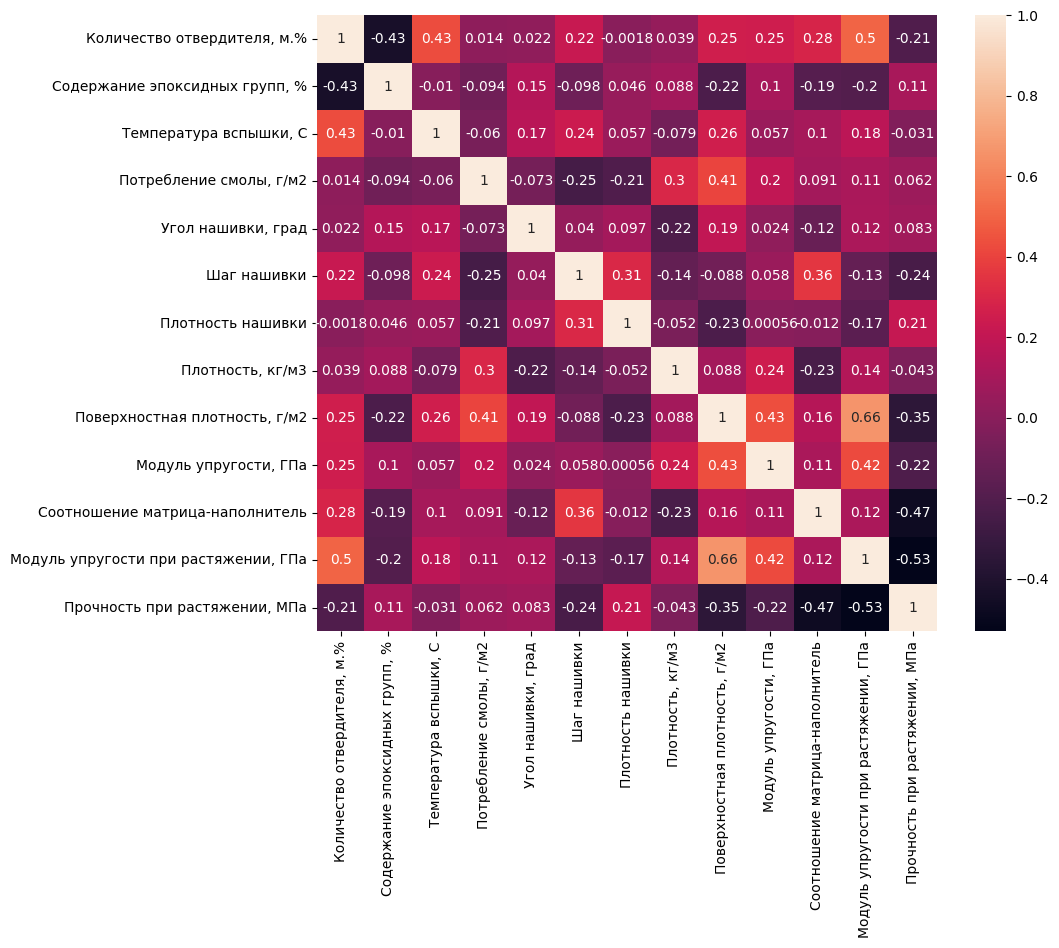

In [5]:
# Корреляции первых 40 строк всего датасета

plt.figure(figsize=(10,8))
sns.heatmap(data[:40].corr(), annot=True)

### 4. Визуализация сгенерированных кластеров

### Isolation Forest

Кластеризация по двум признакам  
<font size=4>Шаг нашивки - Плотность нашивки</font>

In [6]:

# Модель Isolation Forest
isolat = IsolationForest(n_estimators=100, max_samples=200, random_state=0)
data_isolat_label = isolat.fit_predict(data_scale[['Шаг нашивки', "Плотность нашивки"]])

# Количество классов
print(np.unique(data_isolat_label))

# Добавим колонку с меткой класса
data_isolat = data_scale.copy()
data_isolat['label'] = data_isolat_label


[-1  1]


In [7]:
# Метрика для Isolation Forest
silhouette = silhouette_score(data_isolat, data_isolat['label'])
print('Isolation Forest Silhouette Score:', silhouette)

Isolation Forest Silhouette Score: 0.5615723316428368


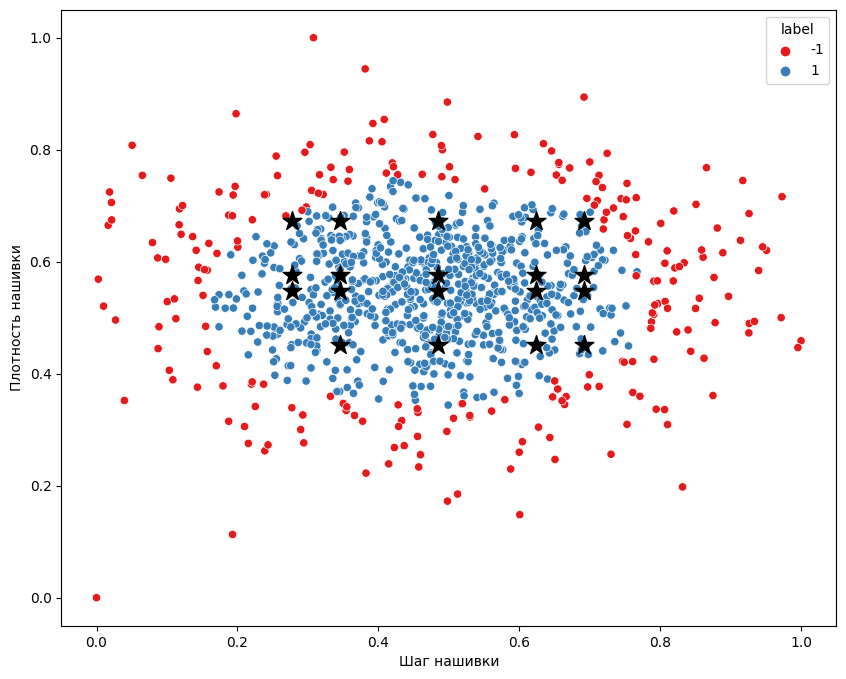

In [8]:
plt.figure(figsize=(10,8))

sns.scatterplot(
                data_isolat, x='Шаг нашивки',
                y="Плотность нашивки",
                hue='label', palette="Set1"
                )
# Добавление реальных значентй в виде звёзд
plt.scatter(data_isolat[:19]['Шаг нашивки'], 
            data_isolat[:19]['Плотность нашивки'],
            s=200, marker='*', c='black')

Isolation Forest больше подходит для выявления аномалий и выбросов

### K-Means  
Подберем количество кластеров и парные признаки, имеющие максимальный коэффициент Силуэта

In [29]:
# датафрейм для записи коэффициентов Силуэта
results_df = pd.DataFrame(columns=['Признак 1', 'Признак 2', 'Число кластеров', 'Silhouette Score'])

# Удалим угол нашивки, принимающий два значения и поэтому дающий максимальный Silhouette
for col1, col2 in combinations(data_scale.drop(columns=['Угол нашивки, град']).columns, 2):
    for i in range(17, 37):
        kmeans = KMeans(i, random_state=0)
        data_kmeans_label = kmeans.fit_predict(data_scale[[col1, col2]])
        data_kmeans = data_scale.copy()
        data_kmeans['label'] = data_kmeans_label
        silhouette = silhouette_score(data_kmeans[[col1, col2]], data_kmeans['label'])
        results_df.loc[len(results_df)] = [col1, col2, i, silhouette]

results_df.shape

(1320, 4)

In [30]:
# Отсортированный по silhouette датафрейм
results_df = results_df.sort_values(by='Silhouette Score', ascending=False)
results_df.head(15)

,Признак 1,Признак 2,Число кластеров,Silhouette Score
1177,"Поверхностная плотность, г/м2","Модуль упругости при растяжении, ГПа",34,0.364207
1175,"Поверхностная плотность, г/м2","Модуль упругости при растяжении, ГПа",32,0.362546
1179,"Поверхностная плотность, г/м2","Модуль упругости при растяжении, ГПа",36,0.361601
154,"Количество отвердителя, м.%","Модуль упругости, ГПа",31,0.360199
157,"Количество отвердителя, м.%","Модуль упругости, ГПа",34,0.359685
834,Шаг нашивки,"Модуль упругости, ГПа",31,0.359185
1176,"Поверхностная плотность, г/м2","Модуль упругости при растяжении, ГПа",33,0.359099
1173,"Поверхностная плотность, г/м2","Модуль упругости при растяжении, ГПа",30,0.358532
676,"Потребление смолы, г/м2","Поверхностная плотность, г/м2",33,0.358094
1039,"Плотность, кг/м3","Поверхностная плотность, г/м2",36,0.356980


<font size=4>Шаг нашивки - Плотность нашивки</font>

In [7]:
kmeans = KMeans(20, random_state=0)
data_kmeans_label = kmeans.fit_predict(data_scale[['Шаг нашивки', "Плотность нашивки"]])

# Добавим колонку с меткой класса
data_kmeans = data_scale.copy()
data_kmeans['label'] = data_kmeans_label

# Метрика для K-Means
silhouette = silhouette_score(data_kmeans[['Шаг нашивки', "Плотность нашивки"]], data_kmeans['label'])
print('KMeans Silhouette Score:', silhouette)


KMeans Silhouette Score: 0.3246026014768662


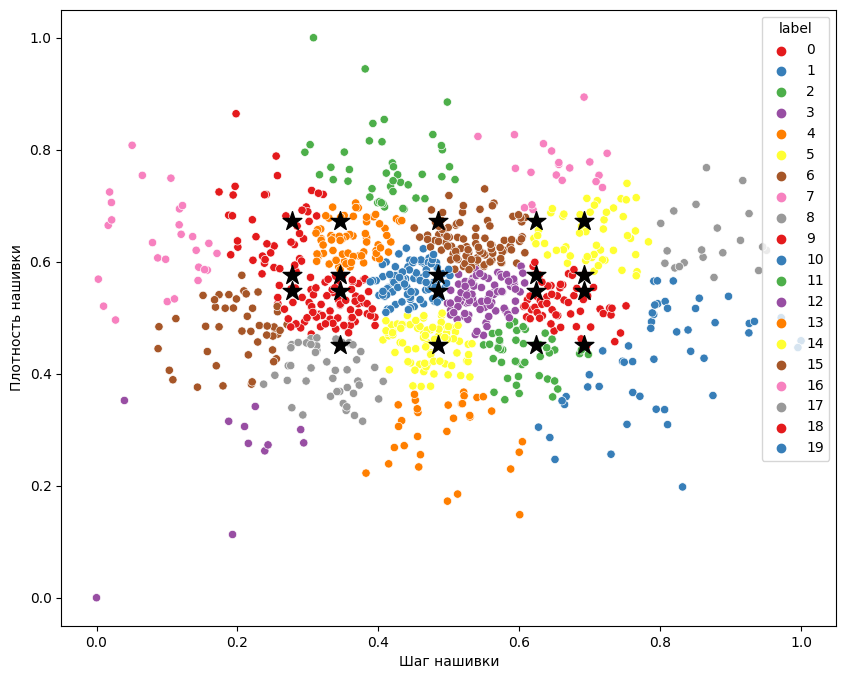

In [10]:
plt.figure(figsize=(10,8))

sns.scatterplot(
                data_kmeans, x='Шаг нашивки',
                y="Плотность нашивки",
                hue='label', palette="Set1"
                )
# Добавление реальных значентй в виде звёзд
plt.scatter(data_kmeans[:19]['Шаг нашивки'], 
            data_kmeans[:19]['Плотность нашивки'], 
            s=200, marker='*', c='black')

<font size=4>Поверхностная плотность - Модуль упругости при растяжении</font>

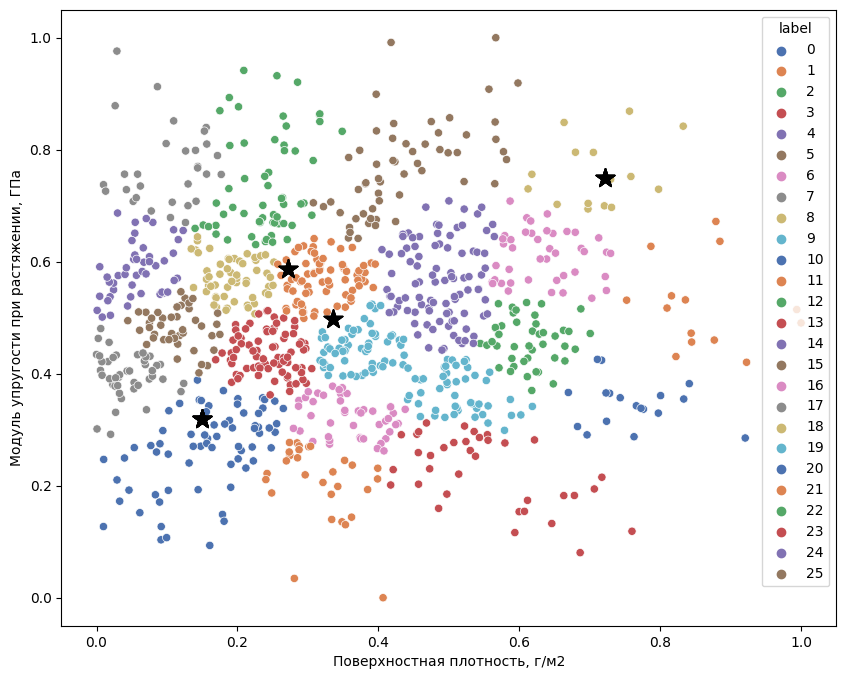

In [34]:
kmeans = KMeans(26, random_state=0)  #32
data_kmeans_label = kmeans.fit_predict(data_scale[['Поверхностная плотность, г/м2', "Модуль упругости при растяжении, ГПа"]])

# Добавим колонку с меткой класса
data_kmeans = data_scale.copy()
data_kmeans['label'] = data_kmeans_label

plt.figure(figsize=(10,8))

sns.scatterplot(
                data_kmeans, x='Поверхностная плотность, г/м2',
                y="Модуль упругости при растяжении, ГПа",
                hue='label', palette="deep"
                )
# Добавление реальных значентй в виде звёзд
plt.scatter(data_kmeans[:21]['Поверхностная плотность, г/м2'], 
            data_kmeans[:21]['Модуль упругости при растяжении, ГПа'], 
            s=200, marker='*', c='black')

<font size=4>Модуль упругости - Модуль упругости при растяжении</font>

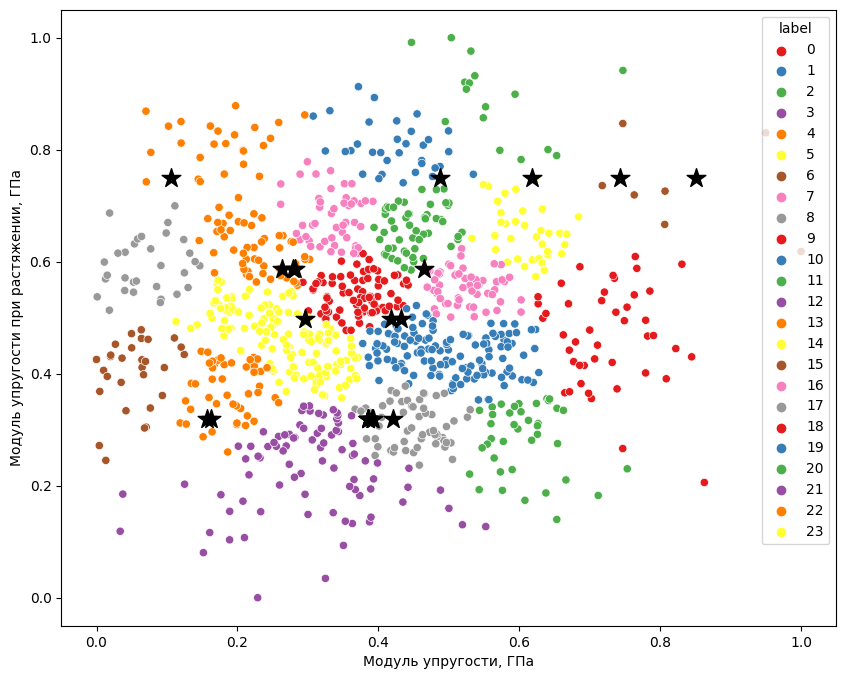

In [36]:
kmeans = KMeans(24, random_state=0)
data_kmeans_label = kmeans.fit_predict(data_scale[['Модуль упругости, ГПа', "Модуль упругости при растяжении, ГПа"]])

# Добавим колонку с меткой класса
data_kmeans = data_scale.copy()
data_kmeans['label'] = data_kmeans_label

plt.figure(figsize=(10,8))

sns.scatterplot(
                data_kmeans, x='Модуль упругости, ГПа',
                y="Модуль упругости при растяжении, ГПа",
                hue='label', palette="Set1"
                )
# Добавление реальных значентй в виде звёзд
plt.scatter(data_kmeans[:21]['Модуль упругости, ГПа'], 
            data_kmeans[:21]['Модуль упругости при растяжении, ГПа'], 
            s=200, marker='*', c='black')

<font size=4>Количество отвердителя - Содержание эпоксидных групп</font>

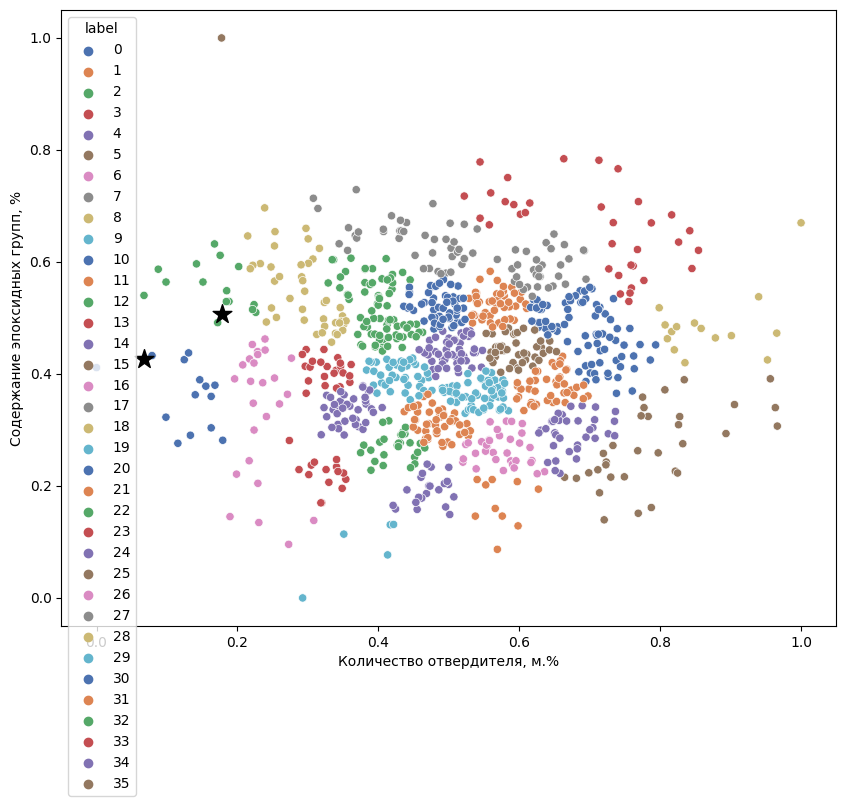

In [12]:
kmeans = KMeans(36, random_state=0)
data_kmeans_label = kmeans.fit_predict(data_scale[['Количество отвердителя, м.%', "Содержание эпоксидных групп, %"]])

# Добавим колонку с меткой класса
data_kmeans = data_scale.copy()
data_kmeans['label'] = data_kmeans_label

plt.figure(figsize=(10,8))
sns.scatterplot(
                data_kmeans, x='Количество отвердителя, м.%',
                y="Содержание эпоксидных групп, %",
                hue='label', palette="deep"
                )
# Добавление реальных значентй в виде звёзд
plt.scatter(data_kmeans[:2]['Количество отвердителя, м.%'], 
            data_kmeans[:2]['Содержание эпоксидных групп, %'], 
            s=200, marker='*', c='black')

<font size=4>Количество отвердителя - Модуль упругости</font>

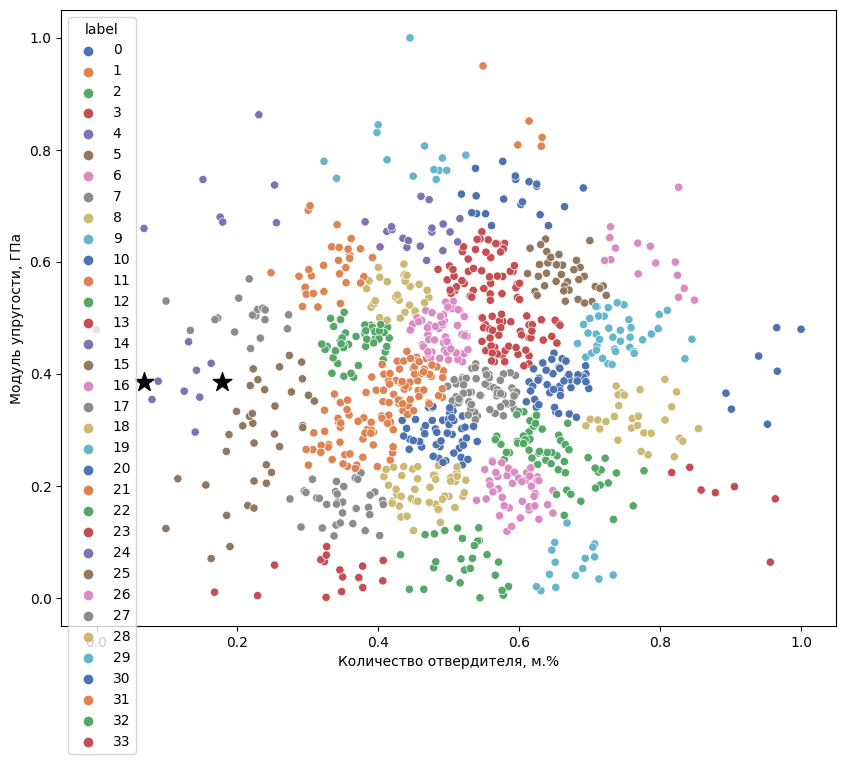

In [32]:
kmeans = KMeans(34, random_state=0)  # 31
data_kmeans_label = kmeans.fit_predict(data_scale[['Количество отвердителя, м.%', "Модуль упругости, ГПа"]])

# Добавим колонку с меткой класса
data_kmeans = data_scale.copy()
data_kmeans['label'] = data_kmeans_label

plt.figure(figsize=(10,8))
sns.scatterplot(
                data_kmeans, x='Количество отвердителя, м.%',
                y="Модуль упругости, ГПа",
                hue='label', palette="deep"
                )
# Добавление реальных значентй в виде звёзд
plt.scatter(data_kmeans[:2]['Количество отвердителя, м.%'], 
            data_kmeans[:2]['Модуль упругости, ГПа'], 
            s=200, marker='*', c='black')

<font size=4>Модуль упругости при растяжении - Прочность при растяжении</font>

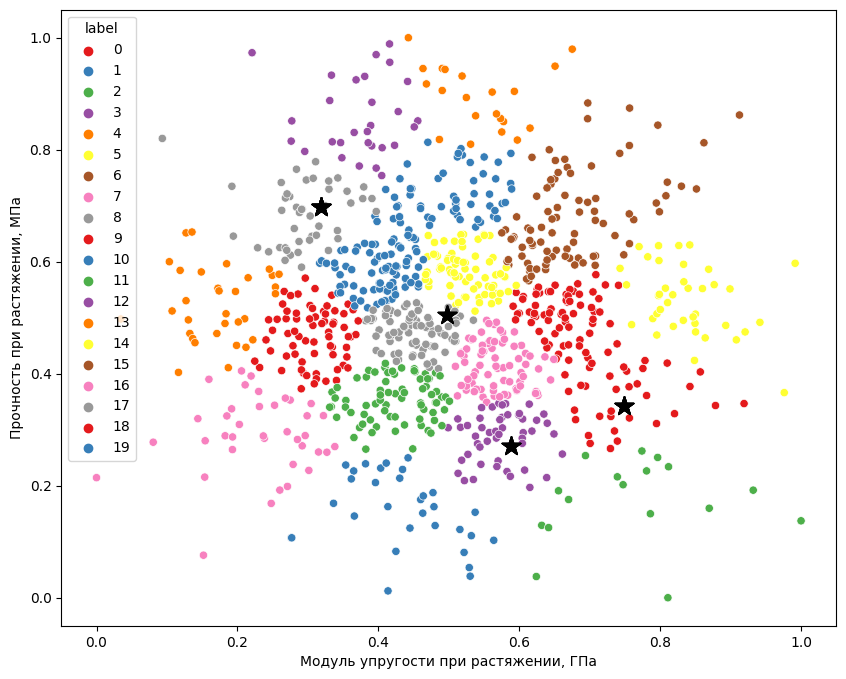

In [13]:
kmeans = KMeans(20, random_state=0)
data_kmeans_label = kmeans.fit_predict(data_scale[['Модуль упругости при растяжении, ГПа', "Прочность при растяжении, МПа"]])

# Добавим колонку с меткой класса
data_kmeans = data_scale.copy()
data_kmeans['label'] = data_kmeans_label

plt.figure(figsize=(10,8))
sns.scatterplot(
                data_kmeans, x='Модуль упругости при растяжении, ГПа',
                y="Прочность при растяжении, МПа",
                hue='label', palette="Set1"
                )
# Добавление реальных значентй в виде звёзд
plt.scatter(data_kmeans[:21]['Модуль упругости при растяжении, ГПа'], 
            data_kmeans[:21]['Прочность при растяжении, МПа'], 
            s=200, marker='*', c='black')

[Далее](https://github.com/Svkhorol/Diploma-Project-Bauman-MSTU/blob/main/notebooks/3_Processing.ipynb)  
[К содержанию](https://github.com/Svkhorol/Diploma-Project-Bauman-MSTU/blob/main/README.md)